<a href="https://colab.research.google.com/github/SBGuillermo/TFM-AnalisisComercio/blob/main/Notebooks/5_Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación de clientes usando métodos de Unsupervised_learning


En este notebooks desarrollaremos diversos modélos de aprendizaje no supervisado para intertar clasificar a nuestros clientes en diferentes grupos con características similares.
Con este sistema podremos entender mejor como actua el conjunto de nuestros clientes y desarrollar acciones más eficientes

En este caso particular, intentaremos generar cluster de clientes teneiendo en cuenta sus gastos y la compra de los 25 objetos más populares de la tienda

Descargaremos el dataset que esta dividido en dos partes, para posteriormente concatanarlo y trabajar sobre él.

In [1]:
# Primero debemos descargar las librerias que sabemos que vamos a utulizar, aunque posteriormente descargaremos otras.
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Descargamos el dataset desde la plataforma github
!wget https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table1.csv

--2021-07-07 07:29:41--  https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17889332 (17M) [text/plain]
Saving to: ‘Table1.csv’

Table1.csv          100%[===================>]  17.06M  27.5MB/s    in 0.6s    

2021-07-07 07:29:42 (27.5 MB/s) - ‘Table1.csv’ saved [17889332/17889332]



In [3]:
!wget https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table2.csv

--2021-07-07 07:29:43--  https://raw.githubusercontent.com/SBGuillermo/TFM-AnalisisComercio/main/DataSet/DataClean/Table2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17784301 (17M) [text/plain]
Saving to: ‘Table2.csv’

Table2.csv          100%[===================>]  16.96M  28.2MB/s    in 0.6s    

2021-07-07 07:29:44 (28.2 MB/s) - ‘Table2.csv’ saved [17784301/17784301]



In [4]:
#Es necesario convertir los dos dataset en Pandas DataFrame para poder trabajar sobre ellos
df1 = pd.read_csv('/content/Table1.csv')
df1

,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,1,536365,71053,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,2,536365,84406B,other,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,3,536365,84029G,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,4,536365,84029E,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,285947,561967,22400,other,3,2011-08-01 13:11:00,0.39,12844.0,United Kingdom,1.17
199996,199996,285948,561967,82482,WOODEN PICTURE FRAME WHITE FINISH,5,2011-08-01 13:11:00,2.55,12844.0,United Kingdom,12.75
199997,199997,285949,561967,82551,other,3,2011-08-01 13:11:00,1.45,12844.0,United Kingdom,4.35
199998,199998,285950,561967,82552,other,3,2011-08-01 13:11:00,1.45,12844.0,United Kingdom,4.35


In [5]:
df2 = pd.read_csv('/content/Table2.csv')
df2

,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,200000,285952,561967,23306,other,3,2011-08-01 13:11:00,1.45,12844.0,United Kingdom,4.35
1,200001,285953,561967,47504H,other,1,2011-08-01 13:11:00,0.79,12844.0,United Kingdom,0.79
2,200002,285954,561967,21907,other,6,2011-08-01 13:11:00,2.10,12844.0,United Kingdom,12.60
3,200003,285955,561967,21992,other,3,2011-08-01 13:11:00,1.25,12844.0,United Kingdom,3.75
4,200004,285956,561967,21754,other,2,2011-08-01 13:11:00,5.95,12844.0,United Kingdom,11.90
...,...,...,...,...,...,...,...,...,...,...,...
197919,397919,541904,581587,22613,other,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
197920,397920,541905,581587,22899,other,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
197921,397921,541906,581587,23254,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
197922,397922,541907,581587,23255,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [6]:
# Concatenamos nuestos dos Dataframe para conseguir el dataset completo 
df = pd.concat([df1,df2], axis=0)
df

,Unnamed: 0,Unnamed: 0.1,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal
0,0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,1,1,536365,71053,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,2,2,536365,84406B,other,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,3,3,536365,84029G,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,4,4,536365,84029E,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...,...
197919,397919,541904,581587,22613,other,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
197920,397920,541905,581587,22899,other,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
197921,397921,541906,581587,23254,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
197922,397922,541907,581587,23255,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [7]:
#borramos las columnas erroneas que no pertenecen al data set inicial
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

Se puede observar en la tabla anterior que exiten un objeto 'other' en la columna 'Descrition'. Esto se debe a que se decidio utilizar solo los 25 objetos a la venta más populares de la tienda. Para más información ver el Notebooks 1_AnalisisComercio_Cleanup

##KMeans

El primer método a utilizar va a ser el de KMeans.

Es un método computacionalme muy sencillo y que tiene una gran versatilidad, pudiendose ser utilizado en practicamente cualquier conjunto de datos. Por eso será nuestra primero opción.

La dos mayores inconveniencia de este método son:
  - Hay que elegir los clusteres antes de llevarlo a cabo

  - No es un método estable, al repetir el proceso te pueden dar resultados diferentes

### One Hot Encoder

Aunque idealmente se podría crear un pipeline que me llevara todos los diferentes procesos de transformación, incluido en OneHotEncode, a la vez, esto no va a ser posible por el tipo de datos que tenemos.

Al estar los datos separados por los distintos objetos de compra y no por cada compra o cliente, nos será necesario agrupar multiples veces los datos despúes de llevar a cabo nuesto OneHotEncoder

In [8]:
#Llevamos a cabo la operación OneHotEncoder con la colunma description (objetos a la venta)
encoder = OneHotEncoder()

encoded = encoder.fit_transform(df['Description'].dropna().values.reshape(-1, 1))

encoded.todense()

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
result_encoding = pd.DataFrame(encoded.todense(), index = df['Description'].dropna().index, columns = encoder.categories_)

In [10]:
result_encoding

,ALARM CLOCK BAKELIKE RED,ASSORTED COLOUR BIRD ORNAMENT,HEART OF WICKER SMALL,JAM MAKING SET WITH JARS,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,LUNCH BAG BLACK SKULL.,LUNCH BAG APPLE DESIGN,LUNCH BAG CARS BLUE,LUNCH BAG PINK POLKADOT,LUNCH BAG RED RETROSPOT,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG SUKI DESIGN,NATURAL SLATE HEART CHALKBOARD,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,PARTY BUNTING,POSTAGE,REGENCY CAKESTAND 3 TIER,REX CASH+CARRY JUMBO SHOPPER,SET OF 3 CAKE TINS PANTRY DESIGN,SET OF 4 PANTRY JELLY MOULDS,SPOTTY BUNTING,WHITE HANGING HEART T-LIGHT HOLDER,WOODEN PICTURE FRAME WHITE FINISH,other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
197920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
197921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
197922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Debemos eliminar la columna 'other' ya que no es un elemento como tal

In [11]:
result_encoding = result_encoding.drop(['other'], axis=1)

Durante el proceso se han modificado los nombres de las columnas, por lo que las rescribiremos, este es un proceso puramente estético para mejorar la legibilidad del DataFrame

In [12]:
#la tranformación ha añadido parentesis a los nombres de las columnas
result_encoding.columns

MultiIndex([(          'ALARM CLOCK BAKELIKE RED',),
            (     'ASSORTED COLOUR BIRD ORNAMENT',),
            (             'HEART OF WICKER SMALL',),
            (          'JAM MAKING SET WITH JARS',),
            (           'JUMBO BAG PINK POLKADOT',),
            (           'JUMBO BAG RED RETROSPOT',),
            (           'LUNCH BAG  BLACK SKULL.',),
            (            'LUNCH BAG APPLE DESIGN',),
            (               'LUNCH BAG CARS BLUE',),
            (           'LUNCH BAG PINK POLKADOT',),
            (           'LUNCH BAG RED RETROSPOT',),
            (         'LUNCH BAG SPACEBOY DESIGN',),
            (             'LUNCH BAG SUKI DESIGN',),
            (    'NATURAL SLATE HEART CHALKBOARD',),
            (   'PACK OF 72 RETROSPOT CAKE CASES',),
            (    'PAPER CHAIN KIT 50'S CHRISTMAS',),
            (                     'PARTY BUNTING',),
            (                           'POSTAGE',),
            (          'REGENCY CAKESTAND 3 TI

In [13]:
result_encoding.columns = ['WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']

Debemos concatenar la tabla inicial con la tabla resultante de los elementos a la venta para relacionar cada una de las transacciones con los elementos comprados

In [18]:
Total_data = pd.DataFrame()
Total_data = pd.concat([df, result_encoding], axis=1)
Total_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,536365,71053,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406B,other,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,536365,84029E,other,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197919,581587,22613,other,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197920,581587,22899,other,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197921,581587,23254,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197922,581587,23255,other,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Con esta tabla tenemos todos los datos transformados para poder llevar a cabo las agrupaciones por comprar y clientes.
Para ello eliminaremos las columnas que no nos interesan para el futuro análisis

In [51]:
ToAnalice_data=Total_data.drop(['StockCode','Description','InvoiceDate', 'UnitPrice', 'Country','InvoiceNo'], axis=1)
ToAnalice_data.head()

,Quantity,CustomerID,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
0,6,17850.0,15.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6,17850.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,17850.0,22.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,17850.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,17850.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este punto del proceso podríamos optar por dos opciones.
  - Intentar crear clusters solo con el dinero gastado y los elementos comprados diferentes cogidos individualmente, sin tener en cuenta el número de dichos elementos
  - O intentar generar clusters utilizando tanto el dinero gastado como la cantidad total de elementos comprados.

La segunda opción es la que se llevará a cabo, porque podría darnos una idea más concreta de las características de los clientes, al no peder parte de los datos

Para ello, multiplicaremos todas las columnas creadas en el OneHotEncoder por la columna Quantity, que posteriormete eliminaremos

In [52]:
for x in range (4, len(ToAnalice_data.columns)):
  ToAnalice_data.iloc[:,x] = ToAnalice_data.iloc[:,x] * ToAnalice_data.iloc[:,0]

In [53]:
ToAnalice_data.head()

,Quantity,CustomerID,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
0,6,17850.0,15.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
1,6,17850.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,17850.0,22.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,17850.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,17850.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
#eliminamos la columna Quantity
ToAnalice_data=ToAnalice_data.drop(['Quantity'], axis=1)

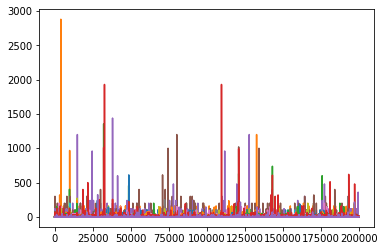

In [55]:
#en esta grafica podemos ver que existen elementos que se compran maxivamente y otros que comprar muy poco.
#Esto habrá que tratarlo posterormente 
Plot_table = ToAnalice_data.drop(['CustomerID','PrecioTotal'], axis=1)
Plot_table.plot(legend= False)

Ahora debemos agrupar los datos según los clientes para obtener la información completa de cada no de esos clientes

In [85]:
#aparte de agrupar los datos debemos sumarlos para obtener los datos finales
Final_data = ToAnalice_data.groupby(['CustomerID'], axis=0).sum()
Final_data.head()

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,77183.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,4310.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,1797.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,1757.55,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,334.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En la gráfica siguiente podemos ver que exite un grupo reducido de clientes que compra gran cantidas de productos y el resto se mantiene en un nivel medio o bajo

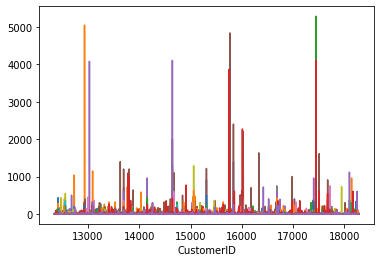

In [64]:
Final_data_plot=Final_data.drop(['PrecioTotal'],axis=1)
Final_data_plot.plot(legend= False)

A continuación vamos a explorar los datos viendo la grafica de cada una de las columnas

In [83]:
col = ['PrecioTotal','WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JUMBO BAG RED RETROSPOT', 'ASSORTED COLOUR BIRD ORNAMENT',
       'PARTY BUNTING', 'LUNCH BAG RED RETROSPOT',
       'SET OF 3 CAKE TINS PANTRY DESIGN', 'LUNCH BAG  BLACK SKULL.',
       'JAM MAKING SET PRINTED', 'PACK OF 72 RETROSPOT CAKE CASES',
       "PAPER CHAIN KIT 50'S CHRISTMAS", 'SPOTTY BUNTING',
       'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG CARS BLUE',
       'HEART OF WICKER SMALL', 'NATURAL SLATE HEART CHALKBOARD',
       'LUNCH BAG PINK POLKADOT', 'REX CASH+CARRY JUMBO SHOPPER',
       'LUNCH BAG SUKI DESIGN', 'ALARM CLOCK BAKELIKE RED',
       'LUNCH BAG APPLE DESIGN', 'SET OF 4 PANTRY JELLY MOULDS',
       'JUMBO BAG PINK POLKADOT', 'JAM MAKING SET WITH JARS',
       'WOODEN PICTURE FRAME WHITE FINISH']

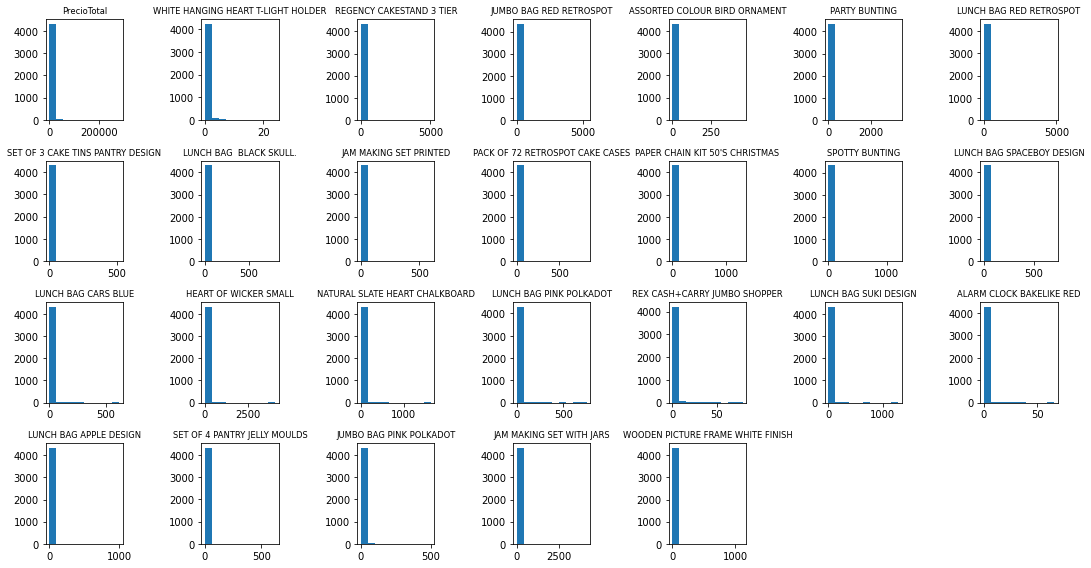

In [98]:
plt.figure(figsize=(15,8))
for i,col in enumerate(Final_data2.columns):
  plt.subplot(4,7,i+1)
  plt.title(col, fontsize='small')
  plt.hist(Final_data2[col])
plt.tight_layout()

De la grafica anteior se pueden concluir dos cosas:
  - que dentro de una misma categoria, siempre la totalidad o casi la totalidad de los elementos estan muy cerca.
  - que existen gran disparidad entre la cantidad de unos elementos y otros.

## Método KMeans

Vamos a seleccionar 5 valores al azar para comparar posteriormente en que cluster los colocaría el modelo

In [70]:
#para ello utilizamos el método sample que te coge aleatoriamente un número de filas
Test_data = Final_data.sample(5)
Test_data

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12471.0,19824.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,107.0,432.0,0.0,36.0,48.0,0.0,0.0,0.0
12370.0,3545.69,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0
16020.0,851.01,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
16698.0,1998.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16159.0,348.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El indice del nuevo dataset de test nos servirá para borrar dichos elementos en el dataset total.

No queremos que se repitan los mismos clientes en ambos dataset ya que desvirtuaria el resultado

In [71]:
Test_data.index

Float64Index([12471.0, 12370.0, 16020.0, 16698.0, 16159.0], dtype='float64', name='CustomerID')

In [75]:
#eliminamos el set de test del total
Final_data2= Final_data.drop(Test_data.index, axis=0)
Final_data2

,PrecioTotal,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,77183.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,4310.00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,1797.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,1757.55,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,334.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,180.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281.0,80.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282.0,178.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


Debido a las diferencias notables entre las distintas cantidades de objetos comprados, y sobre todo, entre estas y el precio final, se hace necesario normalizar los datos para igual los pesos de dichas varaibles en el posterior procesado

In [105]:
from sklearn import preprocessing
Normalized_data = preprocessing.Normalizer().fit_transform(Final_data2)
Normalized_data

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99993271e-01, 1.16008500e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99987462e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.99936918e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99618769e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.77172329e-04, 4.77172329e-03, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Para establecer el número de clusters que necesitamos, vamos a desarrollar la función codo

In [99]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

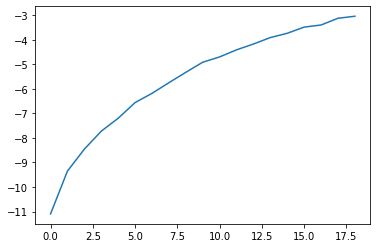

In [101]:
nc = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(Normalized_data).score(Normalized_data) for i in range(len(kmeans))]

plt.plot(score);

En la gráfica anteior vemos que no exite un codo claro en los datos

Podemos probar a normalizar solo los datos de la columna de PrecioTotal al ser la que más desviada esta, dando más peso en el análisis a los productos más comprados

In [134]:
NormalizePrize_data = pd.DataFrame()
NormalizePrize_data['NormalizePrice'] = Final_data2.PrecioTotal
NormalizePrize_data

,NormalizePrice
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
...,...
18280.0,180.60
18281.0,80.82
18282.0,178.05


In [139]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [149]:
NormalizePrize_data_mean = mean_norm(NormalizePrize_data)
NormalizePrize_data_mean

,NormalizePrice
CustomerID,
12346.0,8.358116
12347.0,0.251407
12348.0,-0.028122
12349.0,-0.032537
12350.0,-0.190853
...,...
18280.0,-0.207962
18281.0,-0.219062
18282.0,-0.208246


In [137]:
def mean_norm2(df_input):
    return df_input.apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=0)

In [138]:
mean_norm2(NormalizePrize_data)

,NormalizePrice
CustomerID,
12346.0,0.275453
12347.0,0.015382
12348.0,0.006414
12349.0,0.006272
12350.0,0.001193
...,...
18280.0,0.000645
18281.0,0.000288
18282.0,0.000635


In [148]:
NormalizePrize_data_total = pd.concat([NormalizePrize_data_mean,Final_data2], axis= 1)
NormalizePrize_data_total = NormalizePrize_data_total.drop('PrecioTotal', axis=1)
NormalizePrize_data_total.head()

,NormalizePrice,WHITE HANGING HEART T-LIGHT HOLDER,REGENCY CAKESTAND 3 TIER,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,PARTY BUNTING,LUNCH BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG BLACK SKULL.,JAM MAKING SET PRINTED,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,HEART OF WICKER SMALL,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG PINK POLKADOT,REX CASH+CARRY JUMBO SHOPPER,LUNCH BAG SUKI DESIGN,ALARM CLOCK BAKELIKE RED,LUNCH BAG APPLE DESIGN,SET OF 4 PANTRY JELLY MOULDS,JUMBO BAG PINK POLKADOT,JAM MAKING SET WITH JARS,WOODEN PICTURE FRAME WHITE FINISH
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,8.358116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.251407,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,-0.028122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,-0.032537,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
12350.0,-0.190853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


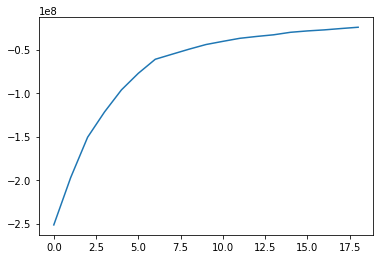

In [151]:
nc = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(NormalizePrize_data_total).score(NormalizePrize_data_total) for i in range(len(kmeans))]

plt.plot(score);

In [152]:
Final_data_cluster = NormalizePrize_data_total.copy()
Final_data_cluster["cluster"] = kmeans.predict(NormalizePrize_data_total)

height = len(Final_data_cluster["cluster"].unique())



AttributeError: ignored

In [ ]:
plt.figure(figsize=(15,2*height))

for i,col in enumerate(cols):
  plt.subplot(1+height,7,i+1)
  plt.title(col)
  plt.hist(Final_data_cluster[col],color="orange")

for j,k in enumerate(dfc_sel_cluster["cluster"].unique()):
  for i,col in enumerate(cols):
    plt.subplot(1+height,7,(7*(j+1))+i+1)
    plt.title(col)
    plt.hist(Final_data_cluster[Final_data_cluster["cluster"]==k][col])
plt.tight_layout();